# Travelling Salesman Problem

This is an homework of Artificial inteligence.

The homework is to code the travelling salesman problem using genetic algorithm.

Group:
- Hendy Rodrigues F. Silva

Id: 1510081

**Homework by Professor Aragão Junior**




### Definitions and auxiliar variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt

coord_x_file = open("data/x.txt","r")
coord_y_file = open("data/y.txt","r")

coord_x = coord_x_file.readlines()
coord_x = list(map(lambda x: int(x.strip()) ,coord_x))

coord_y = coord_y_file.readlines()
coord_y = list(map(lambda x: int(x.strip()) ,coord_y))
cities = list(zip(coord_x, coord_y))

amost = 30

plt.scatter(coord_x, coord_y)

### Auxiliar functions

In [20]:
def euclidian(city_from, city_to):
    return np.sqrt((city_to[0]-city_from[0])**2 + (city_to[1]-city_from[1])**2)

In [21]:
def fitness_func(list_cities_enum, cities):
    sum_euclidian = 0
    aux_city = -1
    for i_city in list_cities_enum:
        if aux_city != -1:
            sum_euclidian += euclidian(cities[aux_city],cities[i_city])
        aux_city = i_city
    return sum_euclidian

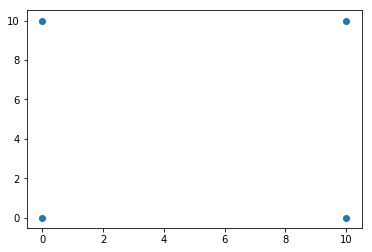

In [22]:
plt.scatter(coord_x, coord_y)

64.14213562373095